In [1]:
import numpy as np
import math
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

Some TODOs<br>
<br>
regarder les missings values toutes ensembles.<br>
genre un plot de type heatmap. En tout cas voir si on a des datas qui manquent dans plusieurs colonnes en même temps.<br>
<br>
Avant d'interpoler, regarder ce qu'on doit prédir.<br>
https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051<br>
Modèle pour prédir les datas météos manquantes au lieu de les interpoler ? (très compliqué pr gain faible % prédictions saisonnières non ?)<br>
<br>
BoxPlot T sur l'année pr tous les sites puis LinePlot site + haute, + basse, médiane<br>
<br>
Le jour de la semaine comme input variable.<br>
<br>
plot matrice des ts les unes contre les autres avec les corrélations et nuages de points.<br>
<br>
google : does pressure has an influence on energy consumption<br>
-> interesting articles on impact of wind

In [2]:
df = pd.read_csv('../data/raw/csvs/weather_train.csv')

<b>I. DataFrame overview</b>

weather_[train/test].csv

 <ul>
    <li>site_id</li>
    <li>air_temperature - Degrees Celsius</li>
    <li>cloud_coverage - Portion of the sky covered in clouds, in oktas</li>
    <li>dew_temperature - Degrees Celsius</li>
    <li>precip_depth_1_hr - Millimeters</li>
    <li>sea_level_pressure - Millibar/hectopascals</li>
    <li>wind_direction - Compass direction (0-360)</li>
    <li>wind_speed - Meters per second</li>
</ul> 

At first, we will particularly look at 4 features (air_temperature, dew_temperature, precip_depth, and wind_direction), because intuitively it feels like those are features with a bigger impact on energy consumption, and/or because they are easy to interpret.

In [3]:
df.shape

(139773, 9)

In [4]:
df.head()

site_id            timestamp  air_temperature  cloud_coverage  \
0        0  2016-01-01 00:00:00             25.0             6.0   
1        0  2016-01-01 01:00:00             24.4             NaN   
2        0  2016-01-01 02:00:00             22.8             2.0   
3        0  2016-01-01 03:00:00             21.1             2.0   
4        0  2016-01-01 04:00:00             20.0             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0                NaN              1019.7             0.0   
1             21.1               -1.0              1020.2            70.0   
2             21.1                0.0              1020.2             0.0   
3             20.6                0.0              1020.1             0.0   
4             20.0               -1.0              1020.0           250.0   

   wind_speed  
0         0.0  
1         1.5  
2         0.0  
3         0.0  
4         2.6

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


We should :
1. Transform 'timestamp' column dtype to datetime
2. Set 'site_id' and 'timestamp' as index

In [6]:
# 1. 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 9.6 MB


In [7]:
# 2. Set index
df.set_index(['site_id','timestamp'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 139773 entries, (0, 2016-01-01 00:00:00) to (15, 2016-12-31 23:00:00)
Data columns (total 7 columns):
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7)
memory usage: 7.9 MB


In [8]:
df.head()

air_temperature  cloud_coverage  dew_temperature  \
site_id timestamp                                                               
0       2016-01-01 00:00:00             25.0             6.0             20.0   
        2016-01-01 01:00:00             24.4             NaN             21.1   
        2016-01-01 02:00:00             22.8             2.0             21.1   
        2016-01-01 03:00:00             21.1             2.0             20.6   
        2016-01-01 04:00:00             20.0             2.0             20.0   

                             precip_depth_1_hr  sea_level_pressure  \
site_id timestamp                                                    
0       2016-01-01 00:00:00                NaN              1019.7   
        2016-01-01 01:00:00               -1.0              1020.2   
        2016-01-01 02:00:00                0.0              1020.2   
        2016-01-01 03:00:00                0.0              1020.1   
        2016-01-01 04:00:00               -1.0              1020.0   

                             wind_direction  wind_speed  
site_id timestamp                                        
0       2016-01-01 00:00:00             0.0         0.0  
        2016-01-01 01:00:00            70.0         1.5  
        2016-01-01 02:00:00             0.0         0.0  
        2016-01-01 03:00:00             0.0         0.0  
        2016-01-01 04:00:00           250.0         2.6

It seems like all 'wind_direction' values are integers, but their dtype is float.<br>
Let's check if it's true, and if so set their dtype to int in order to save memory.

In [9]:
wind_direction = df['wind_direction'].dropna()

# Counts values where 'wind_direction' is not integer.
# count = 0, hence we can convert the 'wind_direction' to ints.
count = wind_direction[~wind_direction.apply(float.is_integer)].count()
print('n non-integer = {}'.format(count))

n non-integer = 0


In [10]:
# We have to use nullable integers because of NaNs.
df2 = df.astype({'wind_direction':'Int32'}, copy=False)
df2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 139773 entries, (0, 2016-01-01 00:00:00) to (15, 2016-12-31 23:00:00)
Data columns (total 7 columns):
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null Int32
wind_speed            139469 non-null float64
dtypes: Int32(1), float64(6)
memory usage: 7.5 MB


In [11]:
df3 = df.astype({'wind_direction':'float32'}, copy=False)
df3.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 139773 entries, (0, 2016-01-01 00:00:00) to (15, 2016-12-31 23:00:00)
Data columns (total 7 columns):
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float32
wind_speed            139469 non-null float64
dtypes: float32(1), float64(6)
memory usage: 7.4 MB


Memory gains are higher with float32 than Int32. Anyway memory is not an issue for the moment so we can keep float64.

<b>II. site_id</b>

In [12]:
site_ids = df.index.get_level_values('site_id').to_series()

# 16 different sites
print(site_ids.unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


<b>III. timestamp</b>

In [13]:
timestamps = df.index.get_level_values('timestamp').to_series()
timestamps.describe()
# (freq=16 means each timestamp appears approx 16 times, (one for each site))
# (top = most freq value)

count                  139773
unique                   8784
top       2016-11-04 05:00:00
freq                       16
first     2016-01-01 00:00:00
last      2016-12-31 23:00:00
Name: timestamp, dtype: object

In [14]:
# One year of data (2016)
print('min : {}'.format(timestamps.min()))
print('max : {}'.format(timestamps.max()))

min : 2016-01-01 00:00:00
max : 2016-12-31 23:00:00


In [15]:
# One point per hour every day
print(np.sort(timestamps.unique())[0:10])
print('n hours in one year : {} ~= 8784 points'.format(365*24))

['2016-01-01T00:00:00.000000000' '2016-01-01T01:00:00.000000000'
 '2016-01-01T02:00:00.000000000' '2016-01-01T03:00:00.000000000'
 '2016-01-01T04:00:00.000000000' '2016-01-01T05:00:00.000000000'
 '2016-01-01T06:00:00.000000000' '2016-01-01T07:00:00.000000000'
 '2016-01-01T08:00:00.000000000' '2016-01-01T09:00:00.000000000']
n hours in one year : 8760 ~= 8784 points


In [16]:
# Extract dataframe with columns 'site_id' and 'timestamp'
index_as_df = df.index.to_frame().reset_index(drop=True)
index_as_df.head()

site_id           timestamp
0        0 2016-01-01 00:00:00
1        0 2016-01-01 01:00:00
2        0 2016-01-01 02:00:00
3        0 2016-01-01 03:00:00
4        0 2016-01-01 04:00:00

We do not have the full time-serie for each site.<br>
Let's compute the number of missing timestamps by site.

In [17]:
# Count timestamps for each site
grouped = index_as_df.groupby(['site_id'])
n_tsp_by_site = grouped.count()
n_tsp_by_site.rename(columns={'timestamp' : 'n_timestamps'}, inplace=True)

# Count total number of unique timestamps in data.
n_tsp_in_timeline = timestamps.unique().shape[0]
print('n unique timestamps = {}'.format(n_tsp_in_timeline))

# Count missing timestamps by sites
n_tsp_by_site['n_missings'] = n_tsp_in_timeline - n_tsp_by_site['n_timestamps']

# Add min and max timestamps for each site.
n_tsp_by_site['min_timestamp'] = grouped.min()
n_tsp_by_site['max_timestamp'] = grouped.max()

n_tsp_by_site

n unique timestamps = 8784


n_timestamps  n_missings       min_timestamp       max_timestamp
site_id                                                                  
0                8784           0 2016-01-01 00:00:00 2016-12-31 23:00:00
1                8763          21 2016-01-01 00:00:00 2016-12-31 23:00:00
2                8783           1 2016-01-01 00:00:00 2016-12-31 23:00:00
3                8780           4 2016-01-01 00:00:00 2016-12-31 23:00:00
4                8783           1 2016-01-01 01:00:00 2016-12-31 23:00:00
5                8755          29 2016-01-01 01:00:00 2016-12-31 23:00:00
6                8782           2 2016-01-01 01:00:00 2016-12-31 23:00:00
7                8614         170 2016-01-01 00:00:00 2016-12-31 23:00:00
8                8784           0 2016-01-01 00:00:00 2016-12-31 23:00:00
9                8780           4 2016-01-01 01:00:00 2016-12-31 23:00:00
10               8782           2 2016-01-01 01:00:00 2016-12-31 23:00:00
11               8614         170 2016-01-01 00:00:00 2016-12-31 23:00:00
12               8755          29 2016-01-01 00:00:00 2016-12-31 23:00:00
13               8783           1 2016-01-01 00:00:00 2016-12-31 23:00:00
14               8777           7 2016-01-01 01:00:00 2016-12-31 23:00:00
15               8454         330 2016-01-01 01:00:00 2016-12-31 23:00:00

First timestamp missing for a few ts.<br>
sites 15, 7, 11 have a lot of missing values.<br>
Let's see if missing value's distribution, i.-e. are they isolated from each other, or do we have time intervals with lots of missings.


In [18]:
# Compute time between two successive timestamps and ad it as a new column 'deltaT'
tsp_diffs = index_as_df['timestamp'].diff()
sites_times = index_as_df.copy()
sites_times['deltaT'] = tsp_diffs

# Drop na (for first computed value)
sites_times.dropna(inplace=True)

# Drop negative values due to diff between last value of site i and first value of site i+1
sites_times.drop(sites_times[sites_times['deltaT']<np.timedelta64(0,'h')].index, inplace=True)

# Drop deltaT == 1h i.e. no missing value between timestamps
sites_times.drop(sites_times[sites_times['deltaT']==np.timedelta64(1,'h')].index, inplace=True)

sites_times.head()

site_id           timestamp   deltaT
9878         1 2016-02-15 18:00:00 05:00:00
9880         1 2016-02-15 21:00:00 02:00:00
9943         1 2016-02-18 13:00:00 02:00:00
9945         1 2016-02-18 20:00:00 06:00:00
10740        1 2016-03-23 03:00:00 05:00:00

In [19]:
# Compute length of missing value intervals for all sites
deltasT_all = sites_times[['deltaT']].copy()
deltasT_all['n'] = 0
deltasT_all.groupby(['deltaT']).count()

n
deltaT              
0 days 02:00:00  286
0 days 03:00:00   43
0 days 04:00:00    8
0 days 05:00:00    9
0 days 06:00:00    7
0 days 07:00:00    4
0 days 08:00:00    5
0 days 09:00:00   13
0 days 11:00:00    2
0 days 12:00:00    2
0 days 15:00:00    1
1 days 16:00:00    2

Most missing timestamps are isolated, meaning that we can perform interpolation to complete. But there are a few longer intervals.
<br>
Note that here, a missing timestamp means that for a site i, we have a missing value for <b>all</b> the features (air_temperature, cloud_coverage, etc).<br>
<br>
It is more useful to look for missing values in each feature timeseries, because we are going to treat missing values feature by feature.<br>
We could plot a heatmap of missing values to visualize it.<br>
<br>
Underneath is the detail for each site of missing timestamp intervals.

In [20]:
# Compute length of missing value intervals for each site
deltasT = sites_times[['site_id', 'deltaT']]
deltasT['n'] = 0
deltasT.groupby(['site_id', 'deltaT']).count()

n
site_id deltaT              
1       0 days 02:00:00    6
        0 days 03:00:00    1
        0 days 05:00:00    2
        0 days 06:00:00    1
2       0 days 02:00:00    1
3       0 days 02:00:00    4
5       0 days 02:00:00    8
        0 days 03:00:00    2
        0 days 04:00:00    1
        0 days 06:00:00    1
        0 days 09:00:00    1
6       0 days 02:00:00    1
7       0 days 02:00:00   46
        0 days 03:00:00   17
        0 days 04:00:00    3
        0 days 05:00:00    2
        0 days 06:00:00    2
        0 days 07:00:00    1
        0 days 08:00:00    1
        0 days 12:00:00    1
        1 days 16:00:00    1
9       0 days 02:00:00    3
10      0 days 02:00:00    1
11      0 days 02:00:00   46
        0 days 03:00:00   17
        0 days 04:00:00    3
        0 days 05:00:00    2
        0 days 06:00:00    2
        0 days 07:00:00    1
        0 days 08:00:00    1
        0 days 12:00:00    1
        1 days 16:00:00    1
12      0 days 02:00:00    8
        0 days 03:00:00    2
        0 days 04:00:00    1
        0 days 05:00:00    1
        0 days 11:00:00    1
13      0 days 02:00:00    1
14      0 days 07:00:00    1
15      0 days 02:00:00  161
        0 days 03:00:00    4
        0 days 05:00:00    2
        0 days 06:00:00    1
        0 days 07:00:00    1
        0 days 08:00:00    3
        0 days 09:00:00   12
        0 days 11:00:00    1
        0 days 15:00:00    1

In [21]:
#hours = data['deltaT'].dt.seconds / 3600.
#hours_clean = hours.drop(index=61430, inplace=False)
#hours_clean.value_counts().sort_index()

<b>IV. air_temperature</b>

In [22]:
# Lets plot air temperature for site 0

df0_T = df.loc[(0,)]['air_temperature']
df0_T.head()

timestamp
2016-01-01 00:00:00    25.0
2016-01-01 01:00:00    24.4
2016-01-01 02:00:00    22.8
2016-01-01 03:00:00    21.1
2016-01-01 04:00:00    20.0
Name: air_temperature, dtype: float64

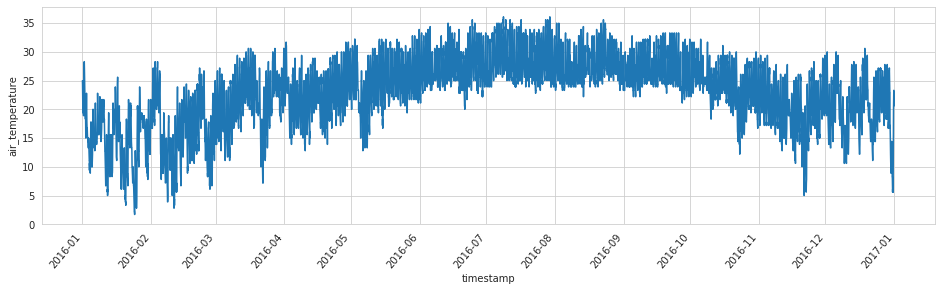

In [23]:
# Plots full 2016 data for site 0

f = plt.figure(figsize=(16,4))
with sns.axes_style("whitegrid"):
    ax = sns.lineplot(x="timestamp", y="air_temperature", data=df0_T.reset_index(inplace=False))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    #ax.xaxis.set_minor_locator(mdates.HourLocator())
    plt.xticks(rotation=50, horizontalalignment='right')

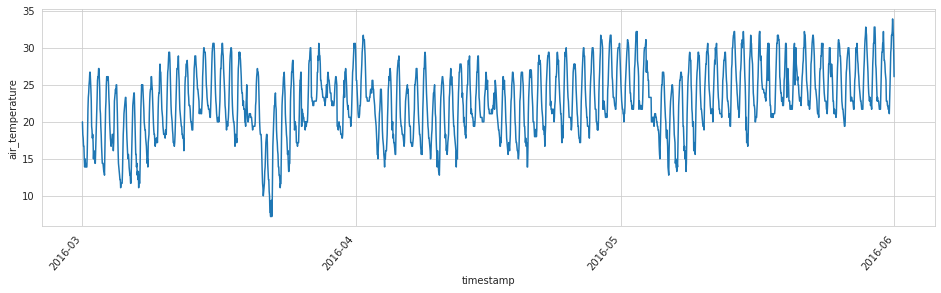

In [24]:
# Fewer months

start = np.datetime64('2016-03-01')
stop = np.datetime64('2016-06-01')
df_plt = df0_T.loc[start:stop]

f = plt.figure(figsize=(16,4))
with sns.axes_style("whitegrid"):
    ax = sns.lineplot(x="timestamp", y="air_temperature", data=df_plt.reset_index(inplace=False))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    #ax.xaxis.set_minor_locator(mdates.HourLocator())
    plt.xticks(rotation=50, horizontalalignment='right')

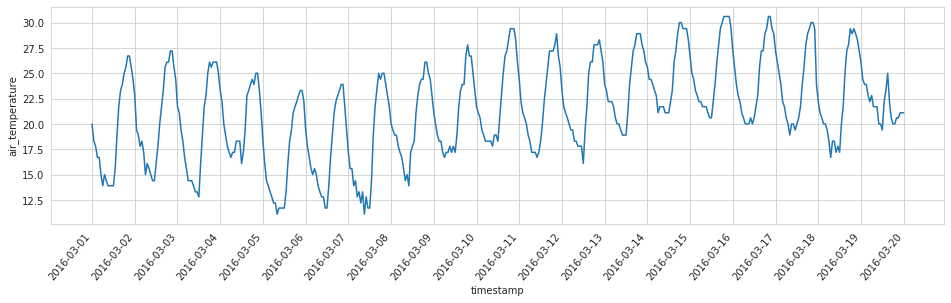

In [25]:
# 20 days

start = np.datetime64('2016-03-01')
stop = np.datetime64('2016-03-20')
df_plt = df0_T.loc[start:stop]

f = plt.figure(figsize=(16,4))
with sns.axes_style("whitegrid"):
    ax = sns.lineplot(x="timestamp", y="air_temperature", data=df_plt.reset_index(inplace=False))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    #ax.xaxis.set_minor_locator(mdates.HourLocator())
    plt.xticks(rotation=50, horizontalalignment='right')

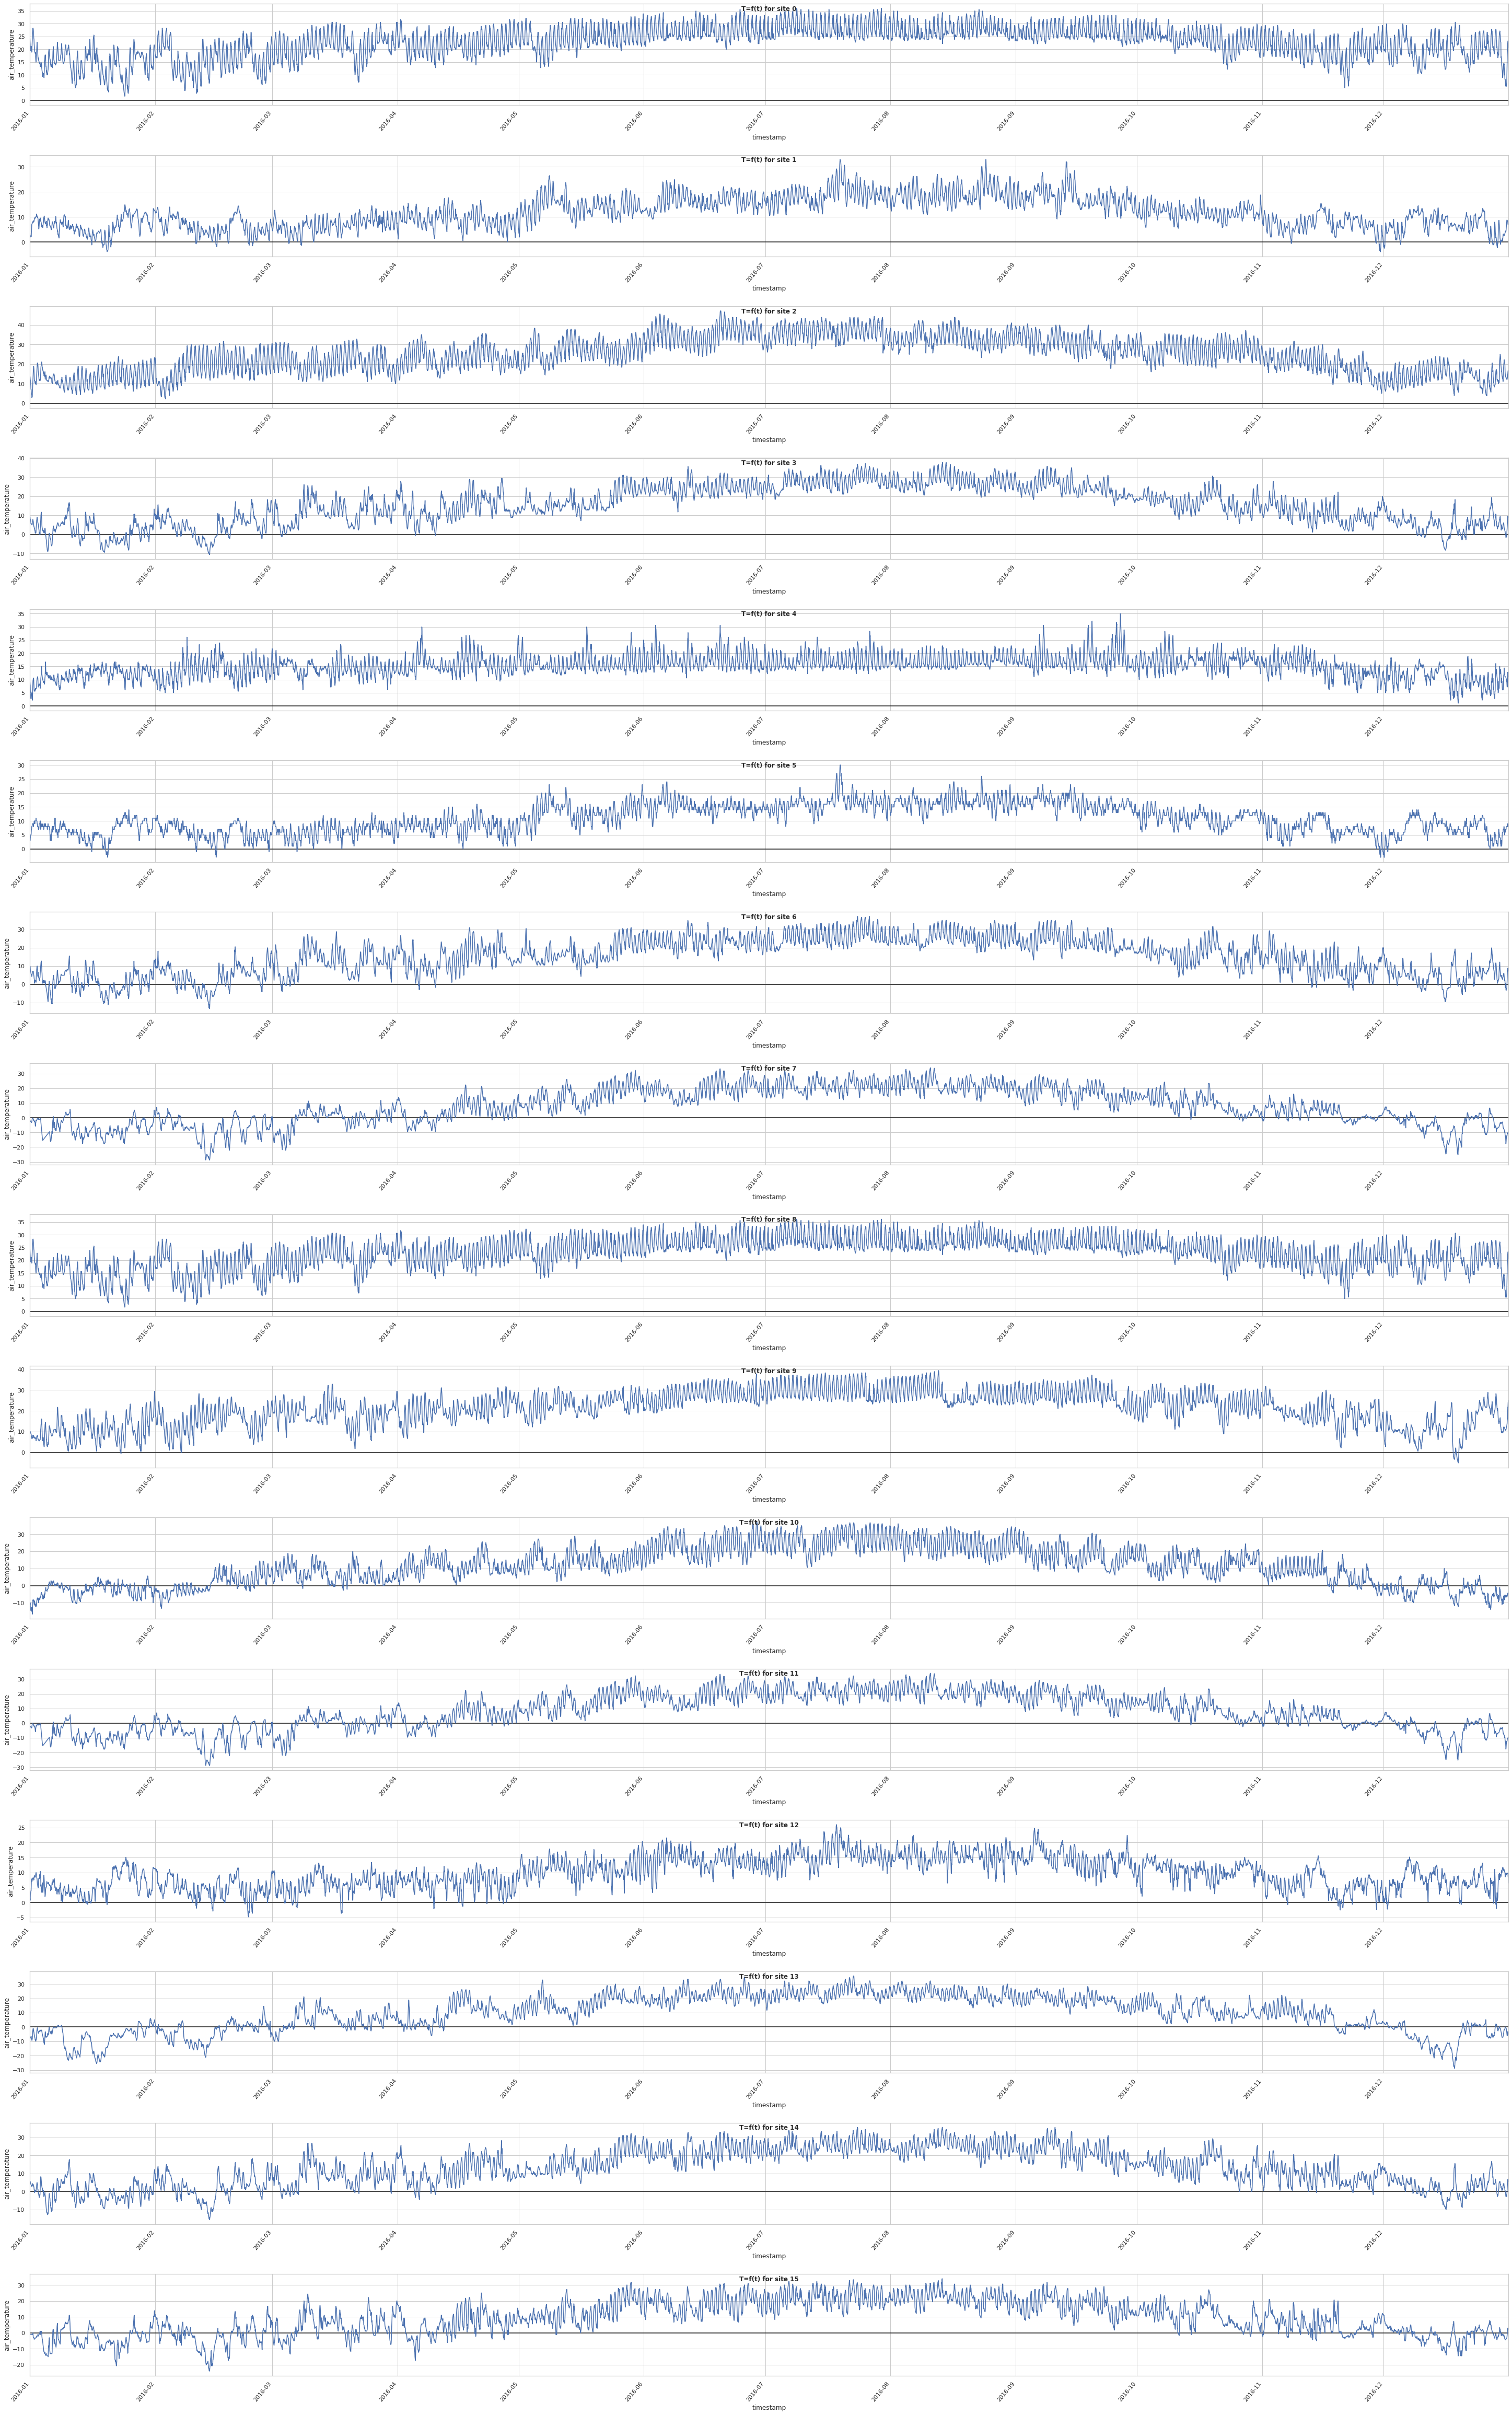

In [42]:
# Plots and saves full 2016 air_temperature data for all sites

do_save = False
n_sites = 16
df_T = df['air_temperature']
fig_T = plt.figure(figsize=(40,n_sites*4))
filename = '../reports/figures/data_exploration/lineplot_air_temperature_data.png'
sns.set(style="whitegrid")

start_date = pd.Series(df_T.index.get_level_values(1)).min()
end_date = pd.Series(df_T.index.get_level_values(1)).max()

for i in range(n_sites):
    
    df_T_i = df_T.loc[i]
    
    plt.subplot(n_sites,1,i+1)
    with sns.axes_style("whitegrid"):
        ax = sns.lineplot(x="timestamp", y="air_temperature", data=df_T_i.reset_index(inplace=False))
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        #ax.xaxis.set_minor_locator(mdates.HourLocator())
        ax.set_title('T=f(t) for site {}'.format(i), y=0.90, fontweight="bold")
        plt.xticks(rotation=50, horizontalalignment='right')
        ax.hlines(0, start_date, end_date)
        plt.xlim(start_date, end_date)
       

plt.tight_layout(pad=0., w_pad=0., h_pad=2.)
if do_save:
    fig_T.savefig(filename)

Observing the 16 timeseries :
<ul>
    <li>All timeseries have a seasonal trend (T=1d).</li>
    <li>There are not evident outliers.</li>
</ul> 

In [27]:
# TODO a plot with only 12:00:00 values, or day mean value ? actually let's compare both

In [28]:
# TODO
# température moyenne par site
# humidité moyenne par site
# vent moyen par site
# precipitation depth par site

Rmqur : on pourrais faire un peu de clustering pour le fun sur les sites

In [32]:
df_T.head()

site_id  timestamp          
0        2016-01-01 00:00:00    25.0
         2016-01-01 01:00:00    24.4
         2016-01-01 02:00:00    22.8
         2016-01-01 03:00:00    21.1
         2016-01-01 04:00:00    20.0
Name: air_temperature, dtype: float64

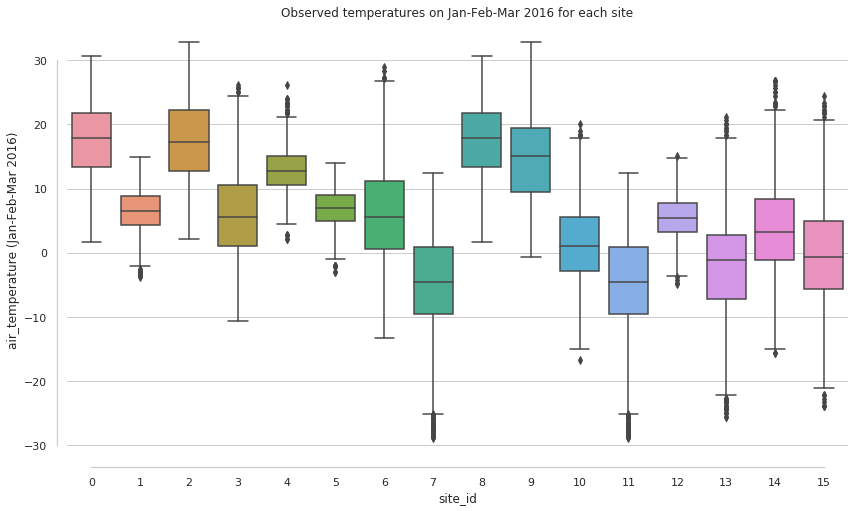

In [34]:
end_date = np.datetime64('2016-04-01')
df_T_end_date = df['air_temperature'].loc[:, : end_date]

#sns.set(style="ticks", palette="pastel")

with sns.color_palette("deep"):
    # Draw a nested boxplot
    plt.figure(figsize=(14,8))
    ax = sns.boxplot(x="site_id", y="air_temperature",
                #palette=["m", "g"],
                data=df_T_end_date.reset_index(level='site_id', inplace=False))
    ax.set_title('Observed temperatures on Jan-Feb-Mar 2016 for each site')
    ax.set_ylabel('air_temperature (Jan-Feb-Mar 2016)')
    sns.despine(offset=10, trim=True)

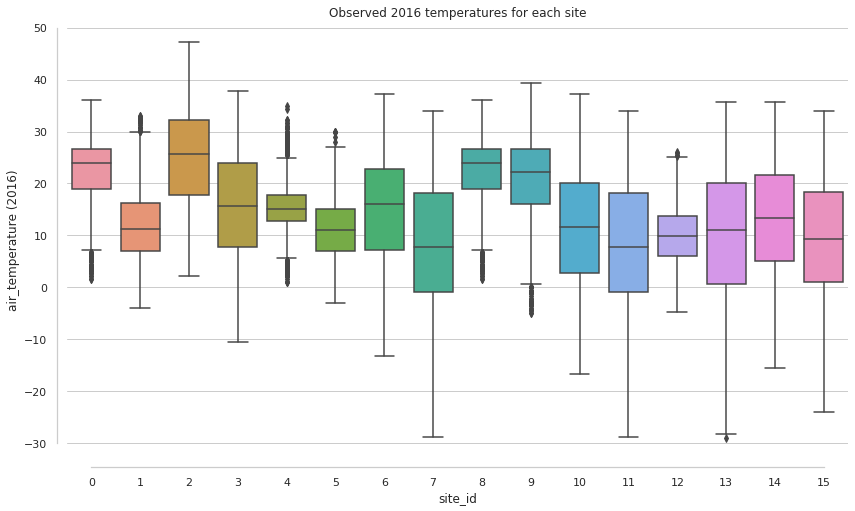

In [35]:

# Draw a nested boxplot
plt.figure(figsize=(14,8))
ax = sns.boxplot(x="site_id", y="air_temperature",
            #palette=["m", "g"],
            data=df_T.reset_index(level='site_id', inplace=False))
ax.set_title('Observed 2016 temperatures for each site')
ax.set_ylabel('air_temperature (2016)')
sns.despine(offset=10, trim=True)

In [49]:
# https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/

# num 39 -> seasonal + trend decomposition
# or https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html

# num 46 -> seasonal plot


<b>V. dew_temperature.</b>

<p>The dew point is the temperature at which air is saturated with water vapor, which is the gaseous state of water.</p>
<p>When air has reached the dew-point temperature at a particular pressure, the water vapor in the air is in equilibrium with liquid water, meaning water vapor is condensing at the same rate at which liquid water is evaporating.</p>
<p>Below the dew point, liquid water will begin to condense on solid surfaces (such as blades of grass) or around solid particles in the atmosphere (such as dust or salt), forming clouds or fog.</p>
<p><b>Dew point is closely linked to relative humidity</b>, which is the ratio of the pressure of water vapor in a parcel of air relative to the saturation pressure of water vapor in that same parcel of air at a specific temperature. Relative humidity (RH) is expressed as a percentage.</p>
<p>The relative humidity is 100 percent when the dew point and the temperature are the same. If the temperature drops any further, condensation will result, and liquid water will begin to form.</p>
<p>Compared to relative humidity, <b>dew point is frequently cited as a more accurate way of measuring the humidity and comfort of the air</b>, since it is an absolute measurement (unlike relative humidity).</p>
<p><b>Most people are comfortable with a dew-point temperature of 60 degrees Fahrenheit (16 degrees Celsius) or lower. At a higher dew point of, for example, 70 F (21 C), most people feel hot or "sticky" because the amount of water vapor in the air slows the evaporation of perspiration and keeps the body from cooling.</b></p>
<p>[https://www.livescience.com/43269-what-is-dew-point.html]</p>


In [36]:
# Lets plot dew_temperature for site 0

df0_DT = df.loc[(0,)]['dew_temperature']
df0_DT.head()

timestamp
2016-01-01 00:00:00    20.0
2016-01-01 01:00:00    21.1
2016-01-01 02:00:00    21.1
2016-01-01 03:00:00    20.6
2016-01-01 04:00:00    20.0
Name: dew_temperature, dtype: float64

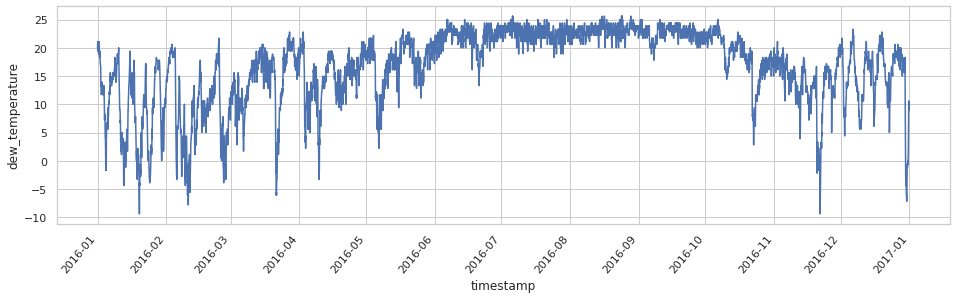

In [38]:
# Plots full 2016 data for site 0

f = plt.figure(figsize=(16,4))
with sns.axes_style("whitegrid"):
    ax = sns.lineplot(x="timestamp", y="dew_temperature", data=df0_DT.reset_index(inplace=False))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    #ax.xaxis.set_minor_locator(mdates.HourLocator())
    plt.xticks(rotation=50, horizontalalignment='right')

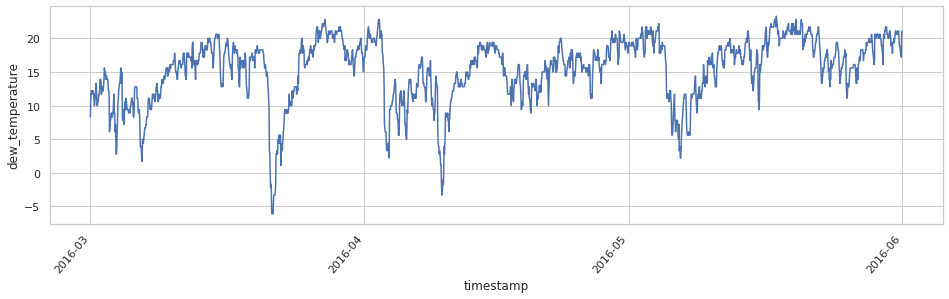

In [39]:
# Fewer months

start = np.datetime64('2016-03-01')
stop = np.datetime64('2016-06-01')
df_plt = df0_DT.loc[start:stop]

f = plt.figure(figsize=(16,4))
with sns.axes_style("whitegrid"):
    ax = sns.lineplot(x="timestamp", y="dew_temperature", data=df_plt.reset_index(inplace=False))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    #ax.xaxis.set_minor_locator(mdates.HourLocator())
    plt.xticks(rotation=50, horizontalalignment='right')

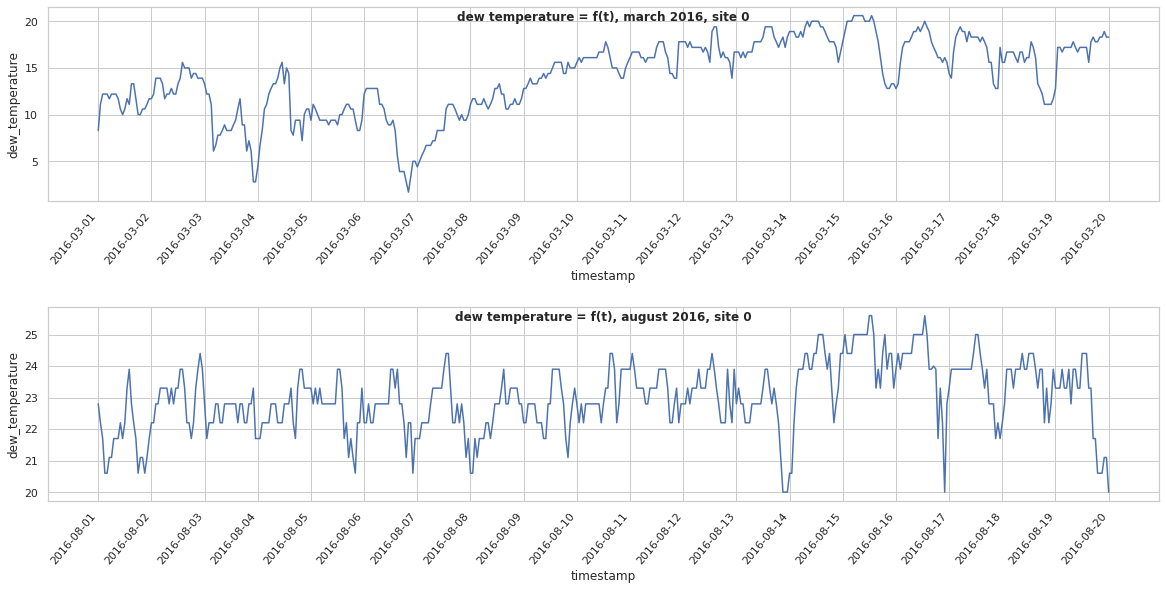

In [46]:
# 20 days (march)

start = np.datetime64('2016-03-01')
stop = np.datetime64('2016-03-20')
df_plt = df0_DT.loc[start:stop]

f = plt.figure(figsize=(16,8))
with sns.axes_style("whitegrid"):
    
    plt.subplot(211)
    ax = sns.lineplot(x="timestamp", y="dew_temperature", data=df_plt.reset_index(inplace=False))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    #ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.set_title('dew temperature = f(t), march 2016, site 0', y=0.90, fontweight="bold")
    plt.xticks(rotation=50, horizontalalignment='right')
    
    
    # 20 days (august)

    start = np.datetime64('2016-08-01')
    stop = np.datetime64('2016-08-20')
    df_plt = df0_DT.loc[start:stop]

    plt.subplot(212)
    ax = sns.lineplot(x="timestamp", y="dew_temperature", data=df_plt.reset_index(inplace=False))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    #ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.set_title('dew temperature = f(t), august 2016, site 0', y=0.90, fontweight="bold")
    plt.xticks(rotation=50, horizontalalignment='right')
    
    plt.tight_layout(pad=0., w_pad=0., h_pad=2.)

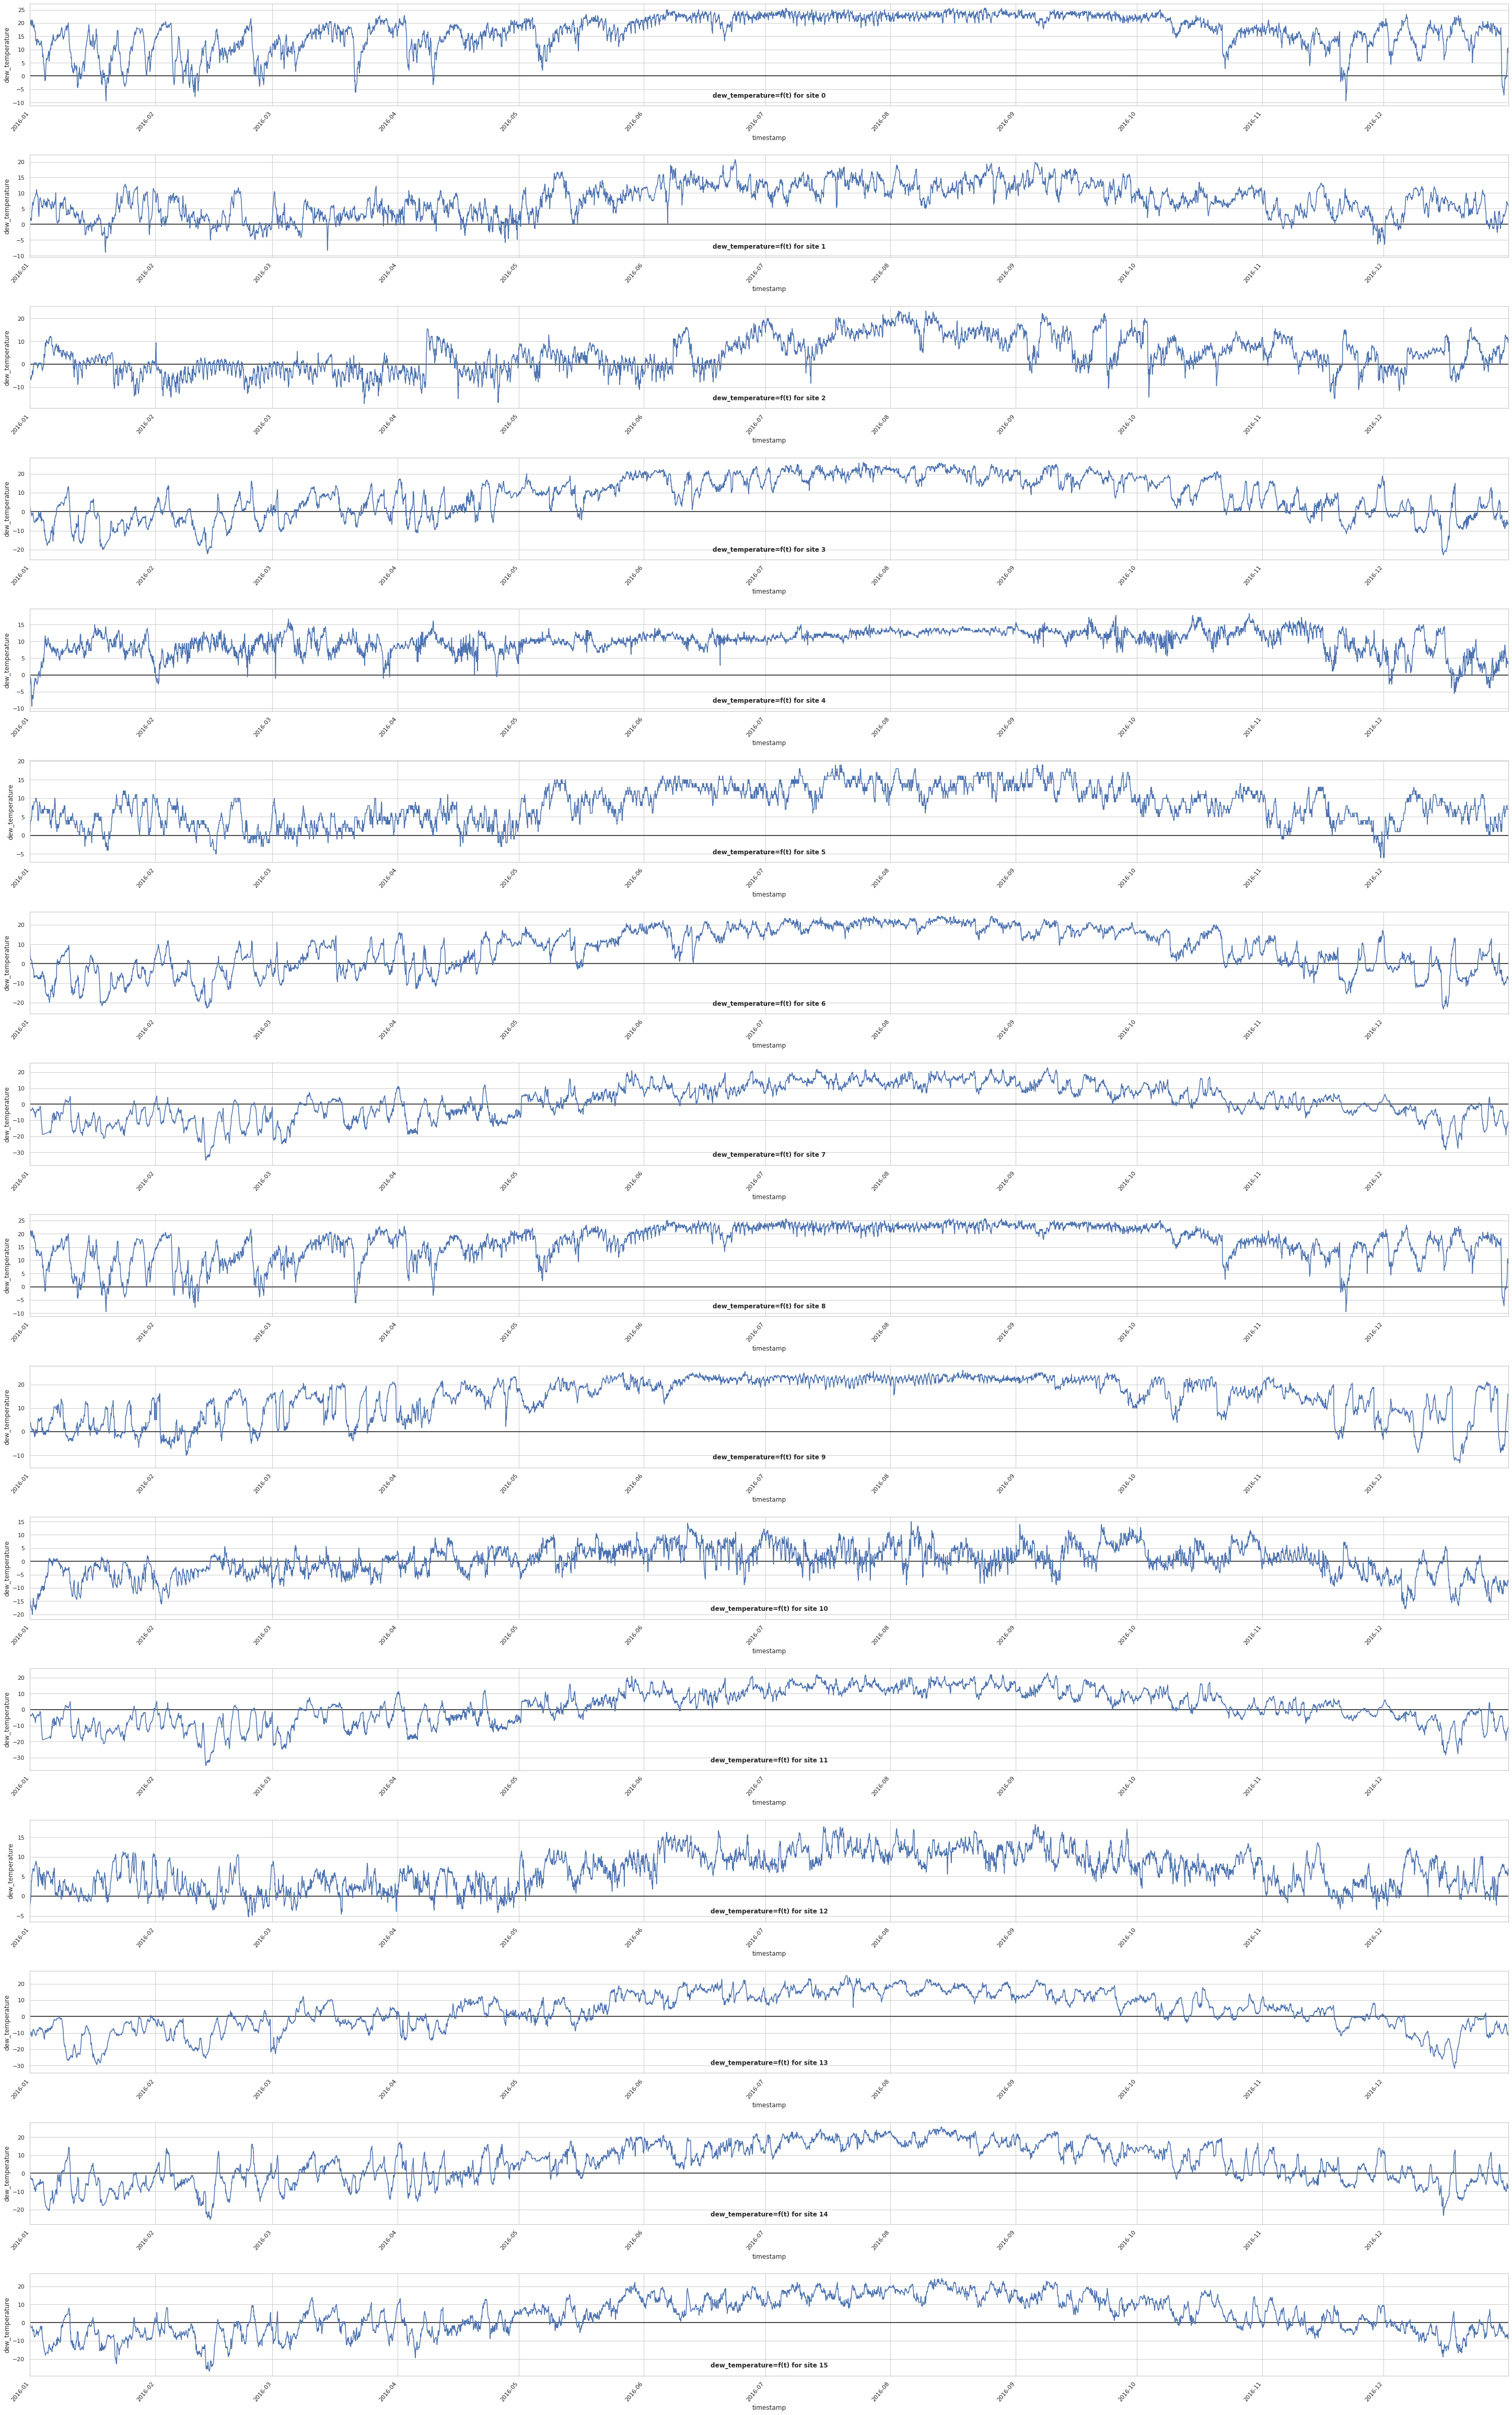

In [52]:
# Plots and saves full 2016 dew temperature data for all sites

# TODO factorize with code for air_temperature plots

do_save = True
n_sites = 16
df_DT = df['dew_temperature']
fig_DT = plt.figure(figsize=(40,n_sites*4))
filename = '../reports/figures/data_exploration/lineplot_dew_temperature_data.png'
sns.set(style="whitegrid")

start_date = pd.Series(df_DT.index.get_level_values(1)).min()
end_date = pd.Series(df_DT.index.get_level_values(1)).max()

for i in range(n_sites):
    
    df_DT_i = df_DT.loc[i]
    
    plt.subplot(n_sites,1,i+1)
    with sns.axes_style("whitegrid"):
        ax = sns.lineplot(x="timestamp", y="dew_temperature", data=df_DT_i.reset_index(inplace=False))
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        #ax.xaxis.set_minor_locator(mdates.HourLocator())
        ax.set_title('dew_temperature=f(t) for site {}'.format(i), y=0.05, fontweight="bold")
        plt.xticks(rotation=50, horizontalalignment='right')
        ax.hlines(0, start_date, end_date)
        plt.xlim(start_date, end_date)
        
plt.tight_layout(pad=0., w_pad=0., h_pad=2.)
if do_save:
    fig_DT.savefig(filename)

TODO comment<br>
<br>
less evident (but small ?)  daily saisonality than for temperature<br>
sites 0, 4, 8, 9 two very distinct regimes summer/winter (less volatile in summer)<br>
no evident outliers<br>

In [54]:
# TODO box plots, all year, summer, winter

<b>VI. precip_depth_1_hr.</b>

The precipitation depth indicates to what depth liquid precipitation would cover a horizontal surface in an observation period if nothing could drain, evaporate or percolate from this surface. The precipitation depth of 1 mm corresponds to a liquid quantity of 1 litre to 1 m² of ground area.


Uneven pattern of precipitation
A significant portion of the annual precipitation in any particular place falls on only a few days, typically about 50% during the 12 days with the most precipitation.(Wikipedia https://en.wikipedia.org/wiki/Precipitation)



In [72]:
# TODO put that higher in notebook and use for first features viz

do_save = False
n_sites = 16

default_filepath = '../reports/figures/data_exploration/' 
#sns.set(style="whitegrid")

def lineplot_multi_sites(df, feature_stg, n_sites, do_save, filename=None, y_title=0.9, bold_0=True):

    df_feat = df[feature_stg]
    fig = plt.figure(figsize=(40,n_sites*4))
    start_date = pd.Series(df_feat.index.get_level_values(1)).min()
    end_date = pd.Series(df_feat.index.get_level_values(1)).max()
    
    for i in range(n_sites):

        df_feat_i = df_feat.loc[i]

        plt.subplot(n_sites,1,i+1)
        with sns.axes_style("whitegrid"):
            ax = sns.lineplot(x="timestamp", y=feature_stg, data=df_feat_i.reset_index(inplace=False))
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            #ax.xaxis.set_minor_locator(mdates.HourLocator())
            ax.set_title('' + feature_stg + '=f(t) for site {}'.format(i), y=y_title, fontweight="bold")
            plt.xticks(rotation=50, horizontalalignment='right')
            if bold_0:
                ax.hlines(0, start_date, end_date)
            plt.xlim(start_date, end_date)

    plt.tight_layout(pad=0., w_pad=0., h_pad=2.)
    if do_save:
        if filename == None:
            default_filename = '' + default_filepath + 'lineplot_' + feature_stg + '_data.png'
            fig.savefig(default_filename)
        else:
            fig.savefig(filename)

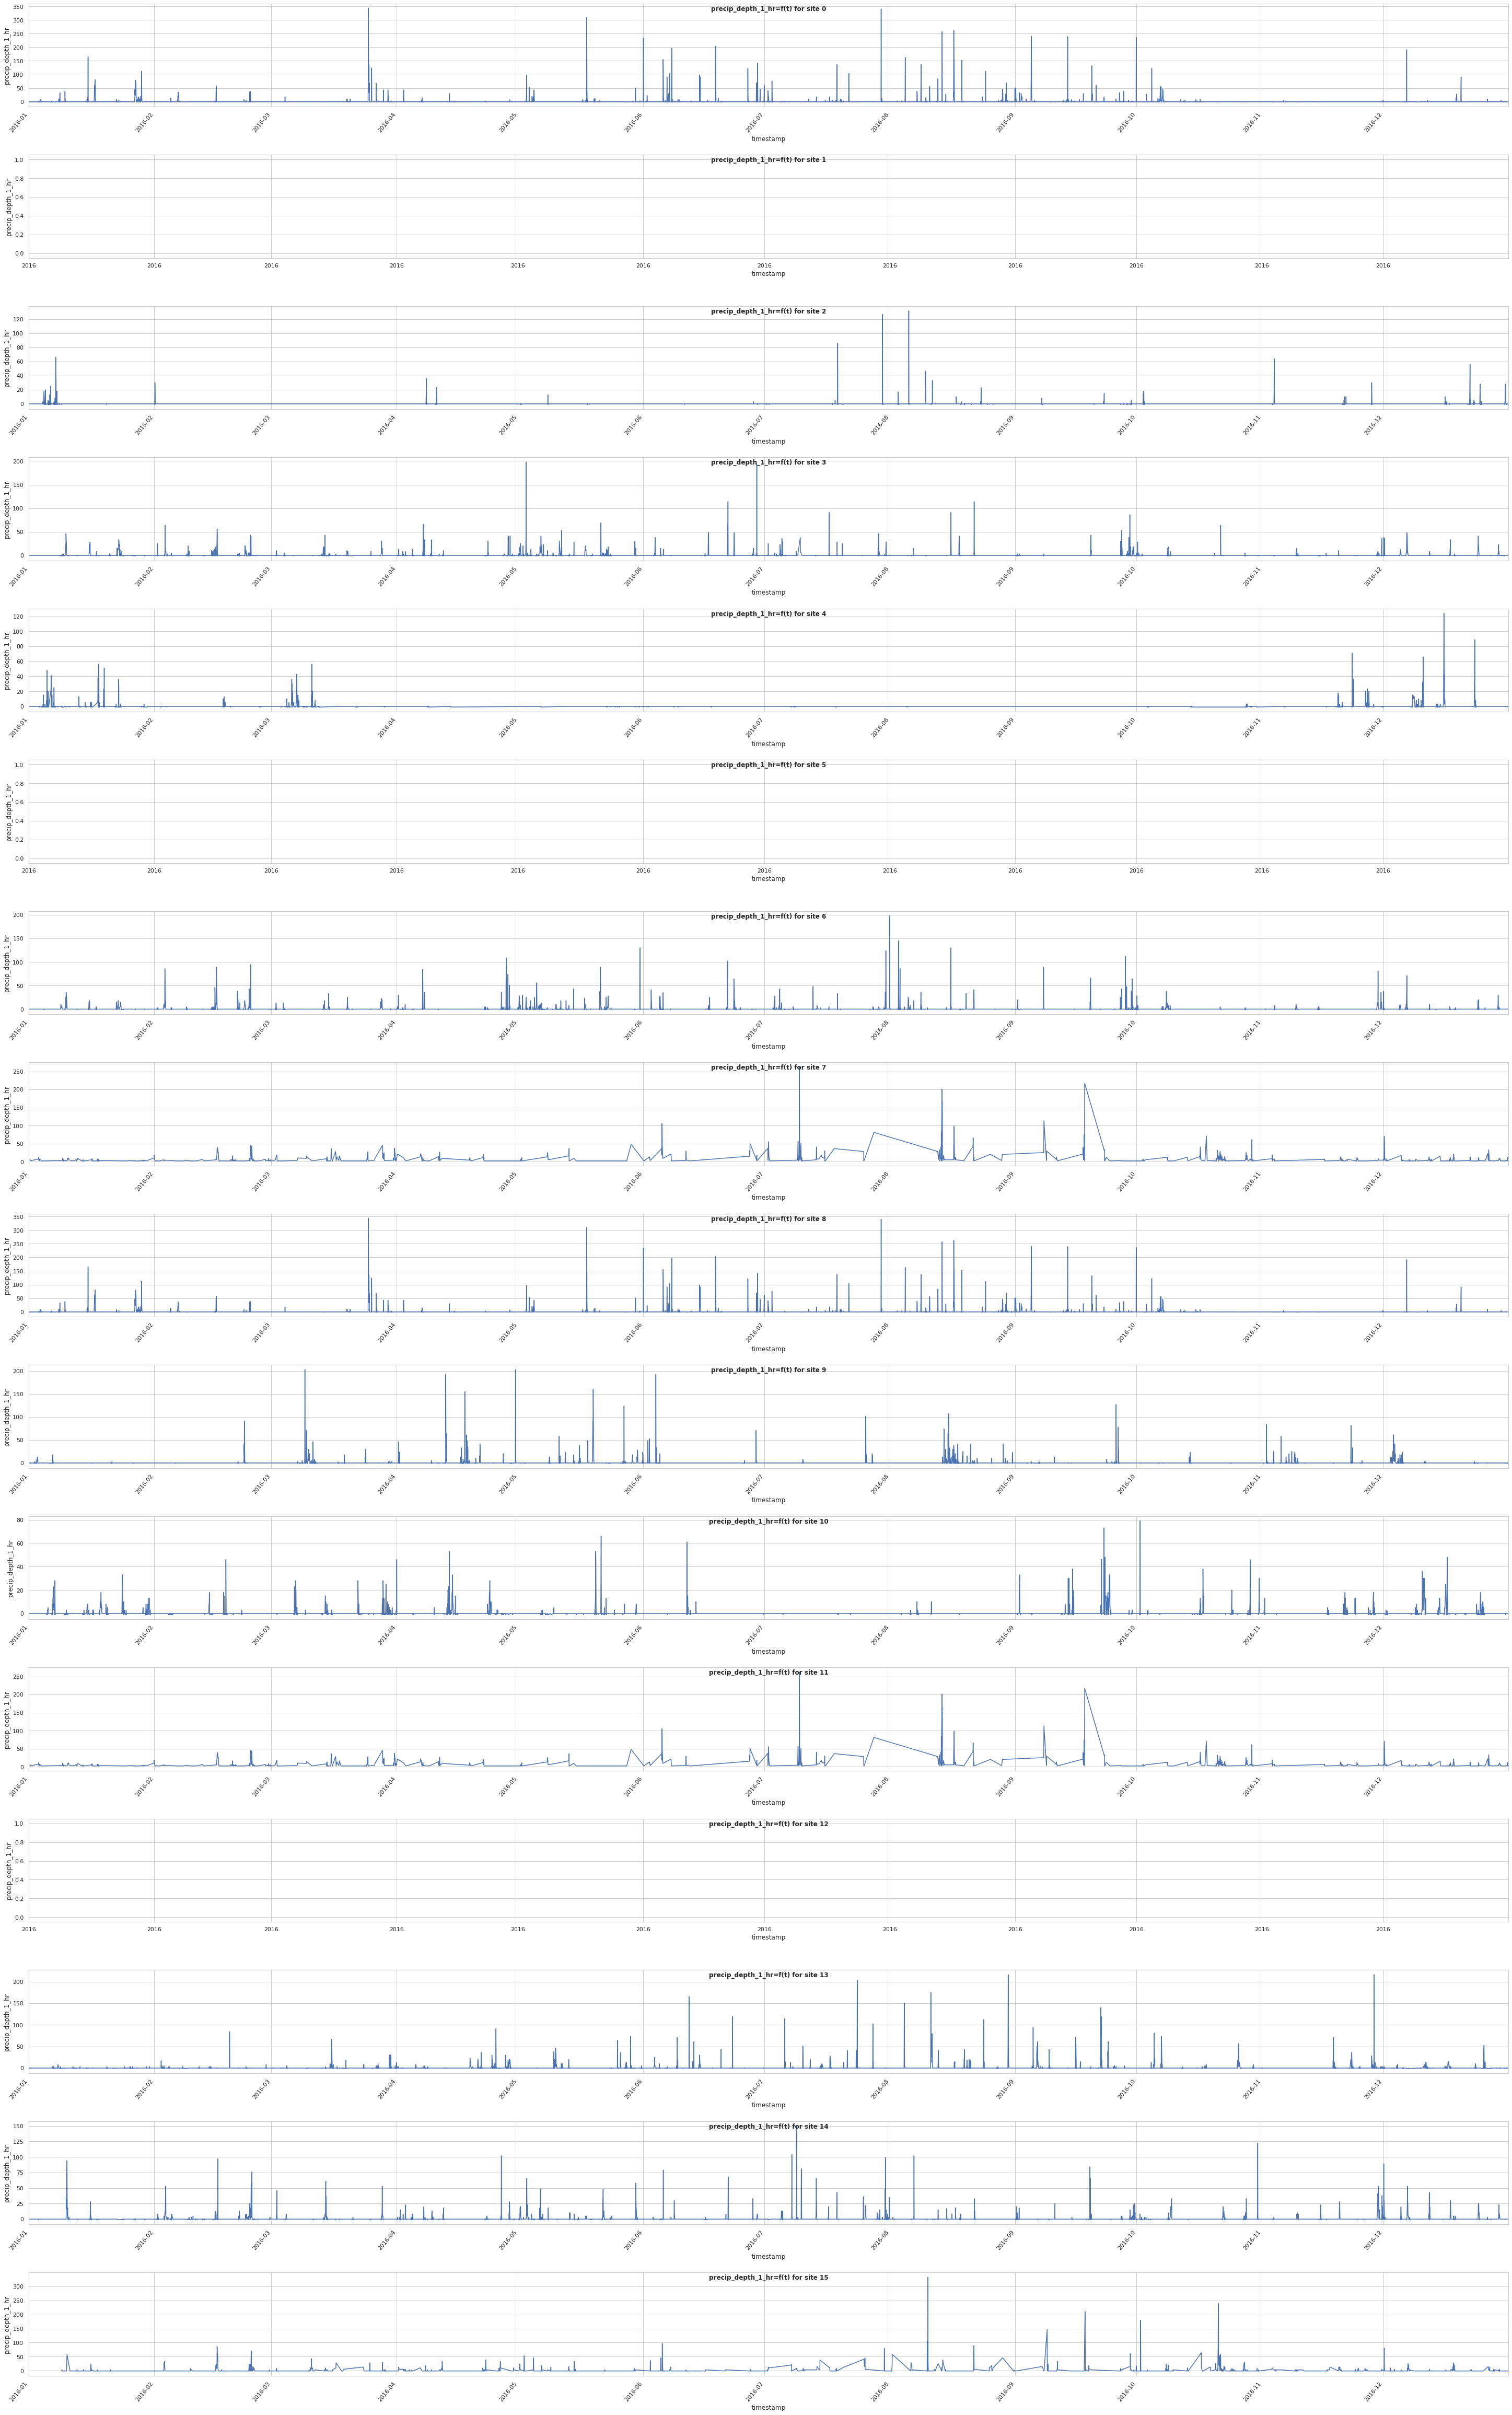

In [73]:
lineplot_multi_sites(df, 'precip_depth_1_hr', 16, True, bold_0=False)

Observations

No daily seasonality.
Very different shape : null most of the time and isolated Diracs -> todo check numerically, ie n_zeros (or n_near_zeros), n_non_zeros, histograms/boxplots, histo when value non-near zero
No data at all for sites 1, 5, and 12 -> TODO check numerically;

order of magnitude :
https://ephyslab.uvigo.es/publica/documents/file_21129-The%20estimation%20of%20probable%20maximun%20precipitation%20the%20case%20of%20Catalonia-ANYAS-2008.pdf
Catalonia -> 350mm per day is great -> 350mm/day ~= 15 mm/h

London 
http://nw3weather.co.uk/wx12.php
Max rain rate
162 mm/h
7th Feb 2016

Most Rain in one hour
33.3 mm
27th Jun 2009

Note 2: The minimum recordable rain (the rain gauge resolution) is 0.2 mm

https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=4&cad=rja&uact=8&ved=2ahUKEwiDl5jCp7bmAhWYFcAKHdFCDfoQFjADegQIDRAF&url=https%3A%2F%2Fwww.wmo.int%2Fpages%2Fprog%2Fwww%2FIMOP%2Fmeetings%2FEdBd-1%2F8_I_6_en_for_EdBd.docx&usg=AOvVaw2vkFPaUUKA9ajwLFBVpO8s
The unit of precipitation is linear depth, usually in millimetres (volume/area), or kg m–2 (mass/area) for liquid precipitation. Daily amounts of precipitation should be read to the nearest 0.2 mm and, if feasible, to the nearest 0.1 mm; weekly or monthly amounts should be read to the nearest 1 mm (at least). Daily measurements of precipitation should be taken at fixed times common to the entire network or networks of interest. Less than 0.1 mm (or 0.2 mm depending on the resolution used) is generally referred to as a trace. 

The measurement unit of rainfall intensity is linear depth per hour, usually in millimetres per hour (mm h–1). Rainfall intensity is normally measured or derived over one-minute time intervals due to the high variability of intensity from minute to minute.

-> TODO add doc in references ?

https://web.archive.org/web/20150309231108/http://www.cocorahs.org/Maps/ViewMap.aspx?state=usa
-> 50 mm/day is considered a lot


-> feature rain_day = 1 or 0 ?

In [74]:
350./24

14.583333333333334

In [75]:
2*25.4

50.8

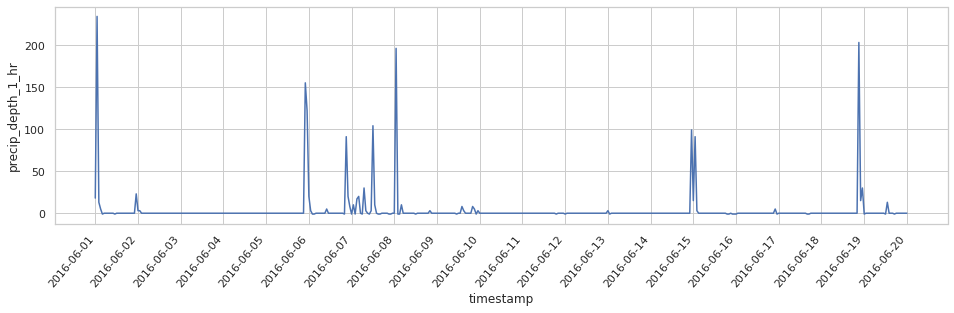

In [77]:
# 20 days


df0_p = df.loc[(0,)]['precip_depth_1_hr']

start = np.datetime64('2016-06-01')
stop = np.datetime64('2016-06-20')
df_plt = df0_p.loc[start:stop]

f = plt.figure(figsize=(16,4))
with sns.axes_style("whitegrid"):
    ax = sns.lineplot(x="timestamp", y="precip_depth_1_hr", data=df_plt.reset_index(inplace=False))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    #ax.xaxis.set_minor_locator(mdates.HourLocator())
    plt.xticks(rotation=50, horizontalalignment='right')

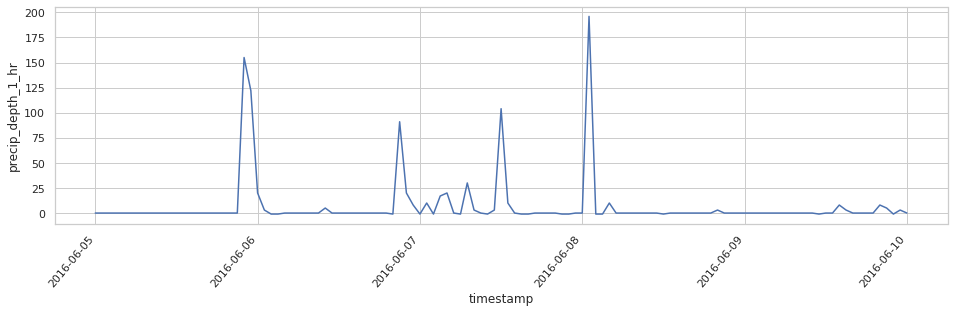

In [83]:
# 20 days


df0_p = df.loc[(0,)]['precip_depth_1_hr']

start = np.datetime64('2016-06-05')
stop = np.datetime64('2016-06-10')
df_plt = df0_p.loc[start:stop]

f = plt.figure(figsize=(16,4))
with sns.axes_style("whitegrid"):
    ax = sns.lineplot(x="timestamp", y="precip_depth_1_hr", data=df_plt.reset_index(inplace=False))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    #ax.xaxis.set_minor_locator(mdates.HourLocator())
    plt.xticks(rotation=50, horizontalalignment='right')

In [86]:
start = np.datetime64('2016-06-05 18:00:00')
stop = np.datetime64('2016-06-06 04:00:00')
df_plt = df0_p.loc[start:stop]
df_plt

timestamp
2016-06-05 18:00:00      0.0
2016-06-05 19:00:00      0.0
2016-06-05 20:00:00      0.0
2016-06-05 21:00:00      0.0
2016-06-05 22:00:00    155.0
2016-06-05 23:00:00    122.0
2016-06-06 00:00:00     20.0
2016-06-06 01:00:00      3.0
2016-06-06 02:00:00     -1.0
2016-06-06 03:00:00     -1.0
2016-06-06 04:00:00      0.0
Name: precip_depth_1_hr, dtype: float64

Looks like it is the daily precip value extrapolating the last 1h precip measure (i.e. measure_1h x 24)

Note : we have -1.0 values !!

In [80]:
33*24

792